<a href="https://colab.research.google.com/github/shubhamphal/One-NLP/blob/master/Sentiment_Analysis_Amazon_product_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
!ls

Gift_Cards.json.gz  sample_data


In [ ]:
!pip install tensorflow_text

In [85]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
!ls

Gift_Cards.json.gz  sample_data


Dataset can be downloaded from http://jmcauley.ucsd.edu/data/amazon/

In [86]:
import pandas as pd
import gzip
import json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Gift_Cards.json.gz')

In [87]:
def get_review_type(rating):
    if rating >=4:
        return 'positive'
    elif rating==3:
        return 'neutral'
    else:
        return 'negative'

In [ ]:
df['review_type']=df['overall'].apply(get_review_type)

In [ ]:
df.head()

overall vote  verified  ... unixReviewTime image review_type
0      1.0   25     False  ...     1229644800   NaN    negative
1      5.0  NaN     False  ...     1229472000   NaN    positive
2      5.0    4     False  ...     1229472000   NaN    positive
3      5.0  NaN     False  ...     1229472000   NaN    positive
4      1.0  NaN      True  ...     1229472000   NaN    negative

[5 rows x 13 columns]

In [ ]:
df=df[['reviewText','review_type']]

In [ ]:
df.shape

(147194, 2)

In [ ]:
df.dropna(axis=0,inplace=True)

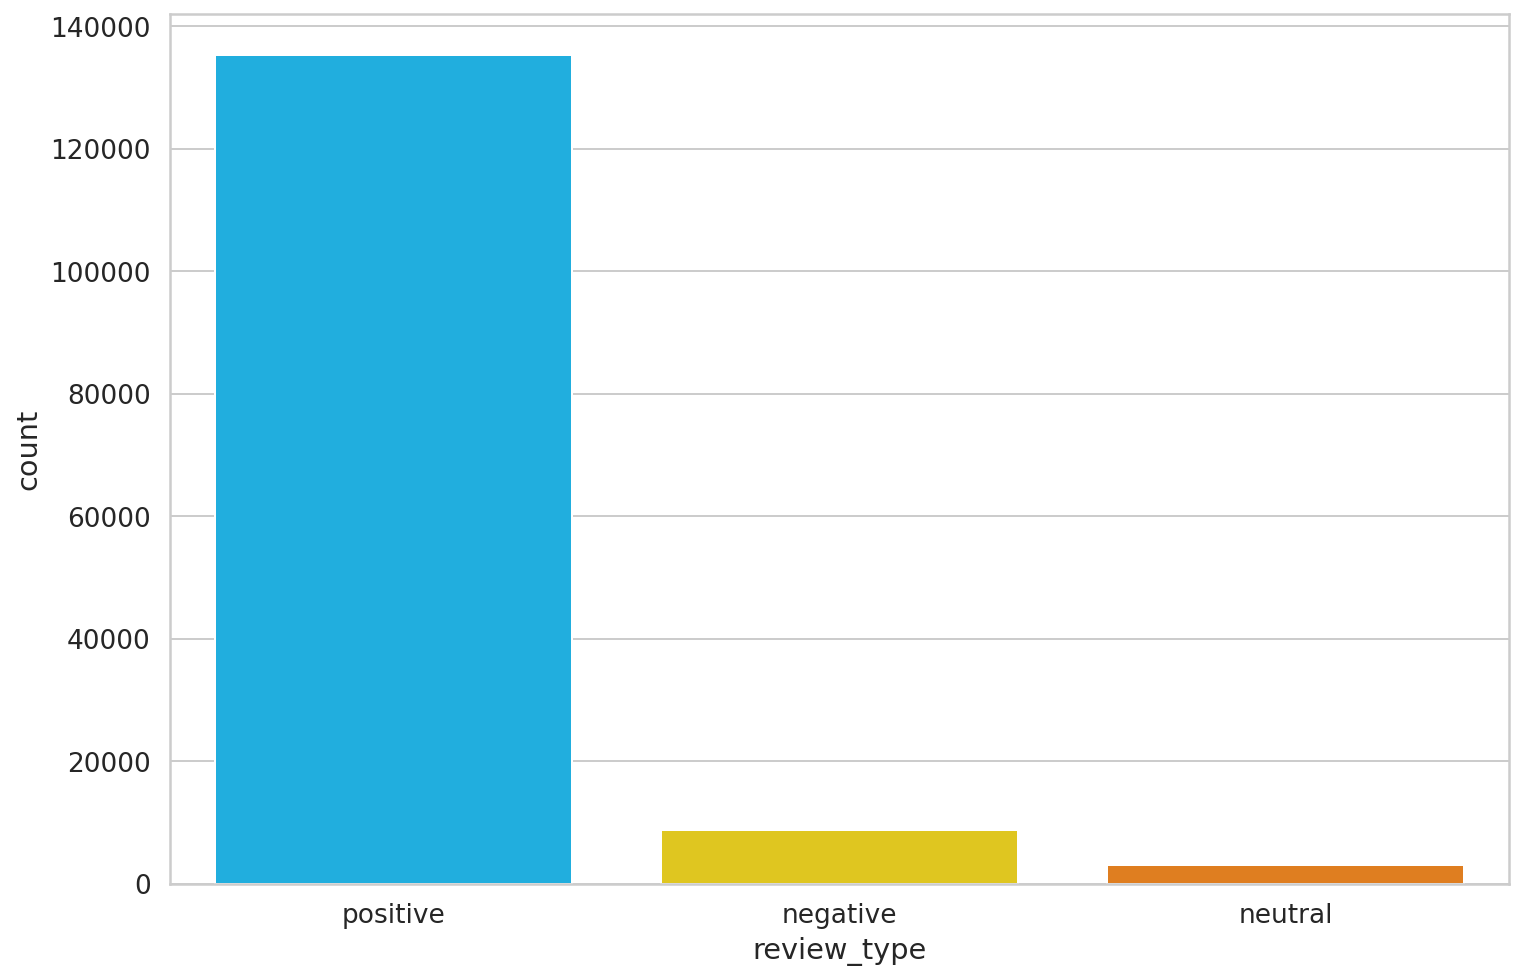

In [ ]:
sns.countplot(
  x='review_type',
  data=df,
  order=df.review_type.value_counts().index
)

In [ ]:
df.review_type.value_counts()

positive    135231
negative      8808
neutral       2996
Name: review_type, dtype: int64

In [ ]:
type(df['reviewText'].iloc[0])

str

In [ ]:
positive_reviews = df[df.review_type == "positive"]
negative_reviews = df[df.review_type == "negative"]
neutral_reviews=df[df.review_type == "neutral"]

Creation of Word cloud to visualize commonly occuring words in positive, negative and neutral reviews

In [ ]:
positive_reviews_text= "".join(str(positive_reviews['reviewText'].to_numpy().tolist()))
negative_reviews_text= "".join(str(negative_reviews.reviewText.to_numpy().tolist()))
neutral_reviews_text="".join(str(neutral_reviews.reviewText.to_numpy().tolist()))

In [ ]:
positive_reviews_text

In [ ]:
positive_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(positive_reviews_text)

In [ ]:
negative_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(negative_reviews_text)

In [ ]:
neutral_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(neutral_reviews_text)

In [ ]:
def show_word_cloud(cloud, title):
    plt.figure(figsize = (16, 10))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show();

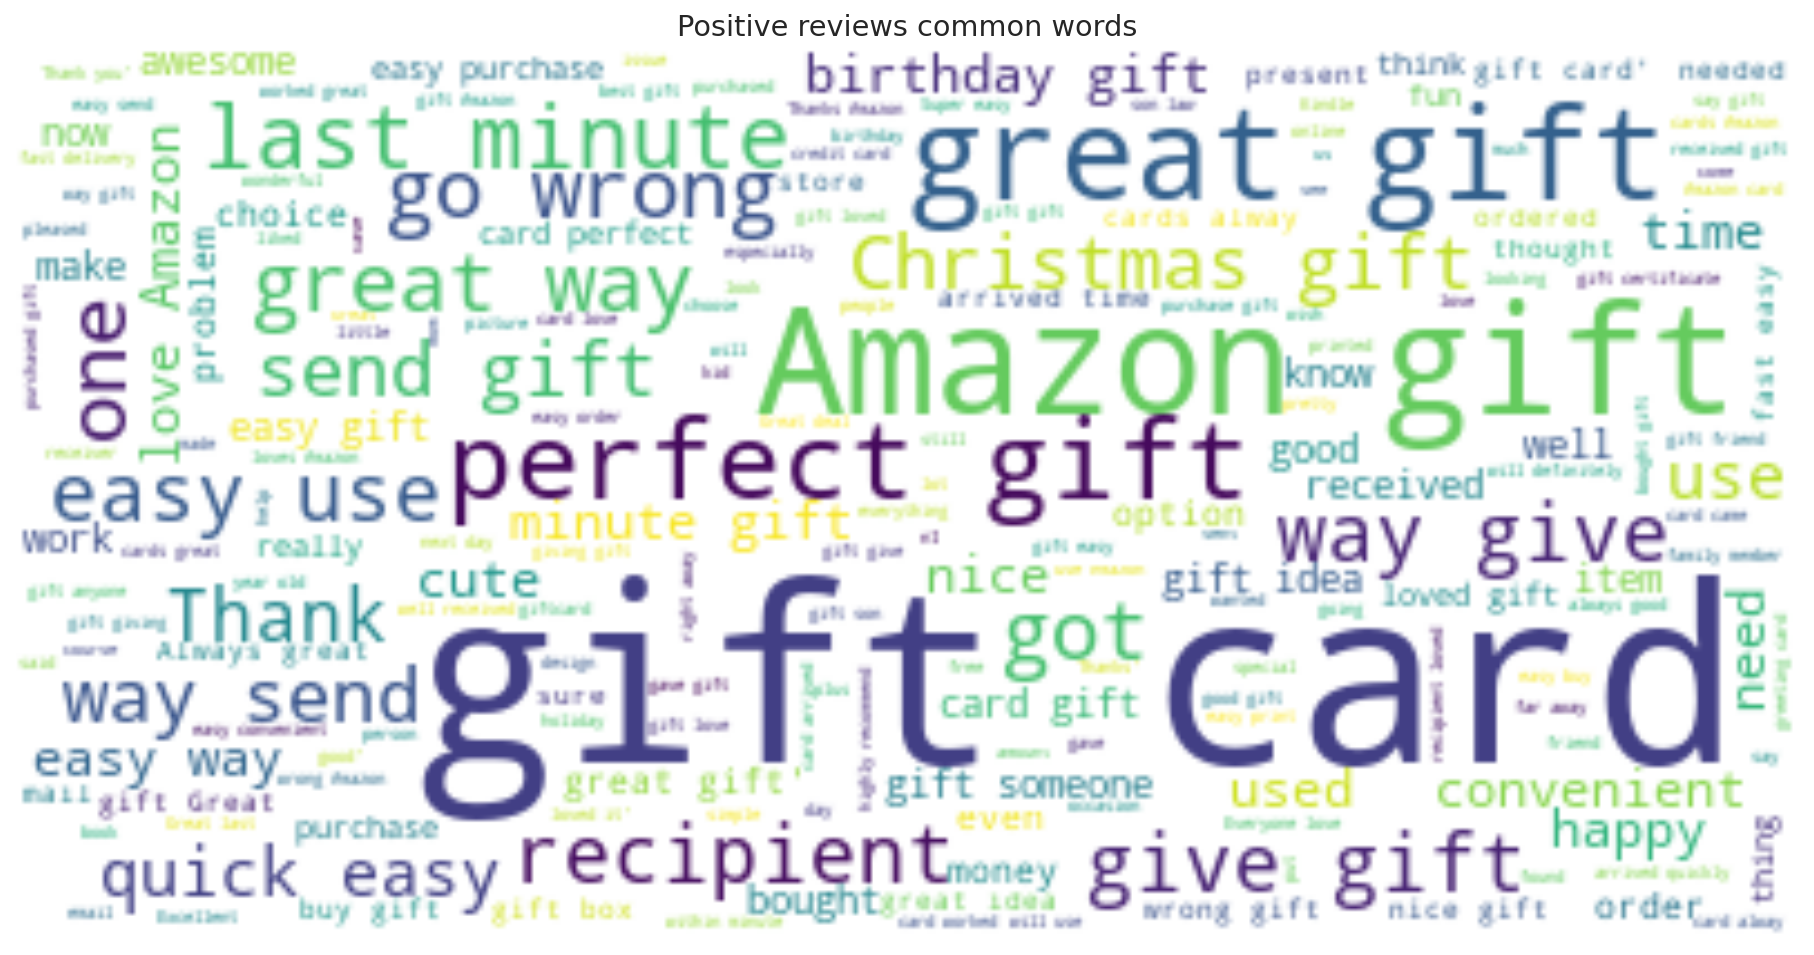

In [ ]:
show_word_cloud(positive_reviews_cloud, "Positive reviews common words")

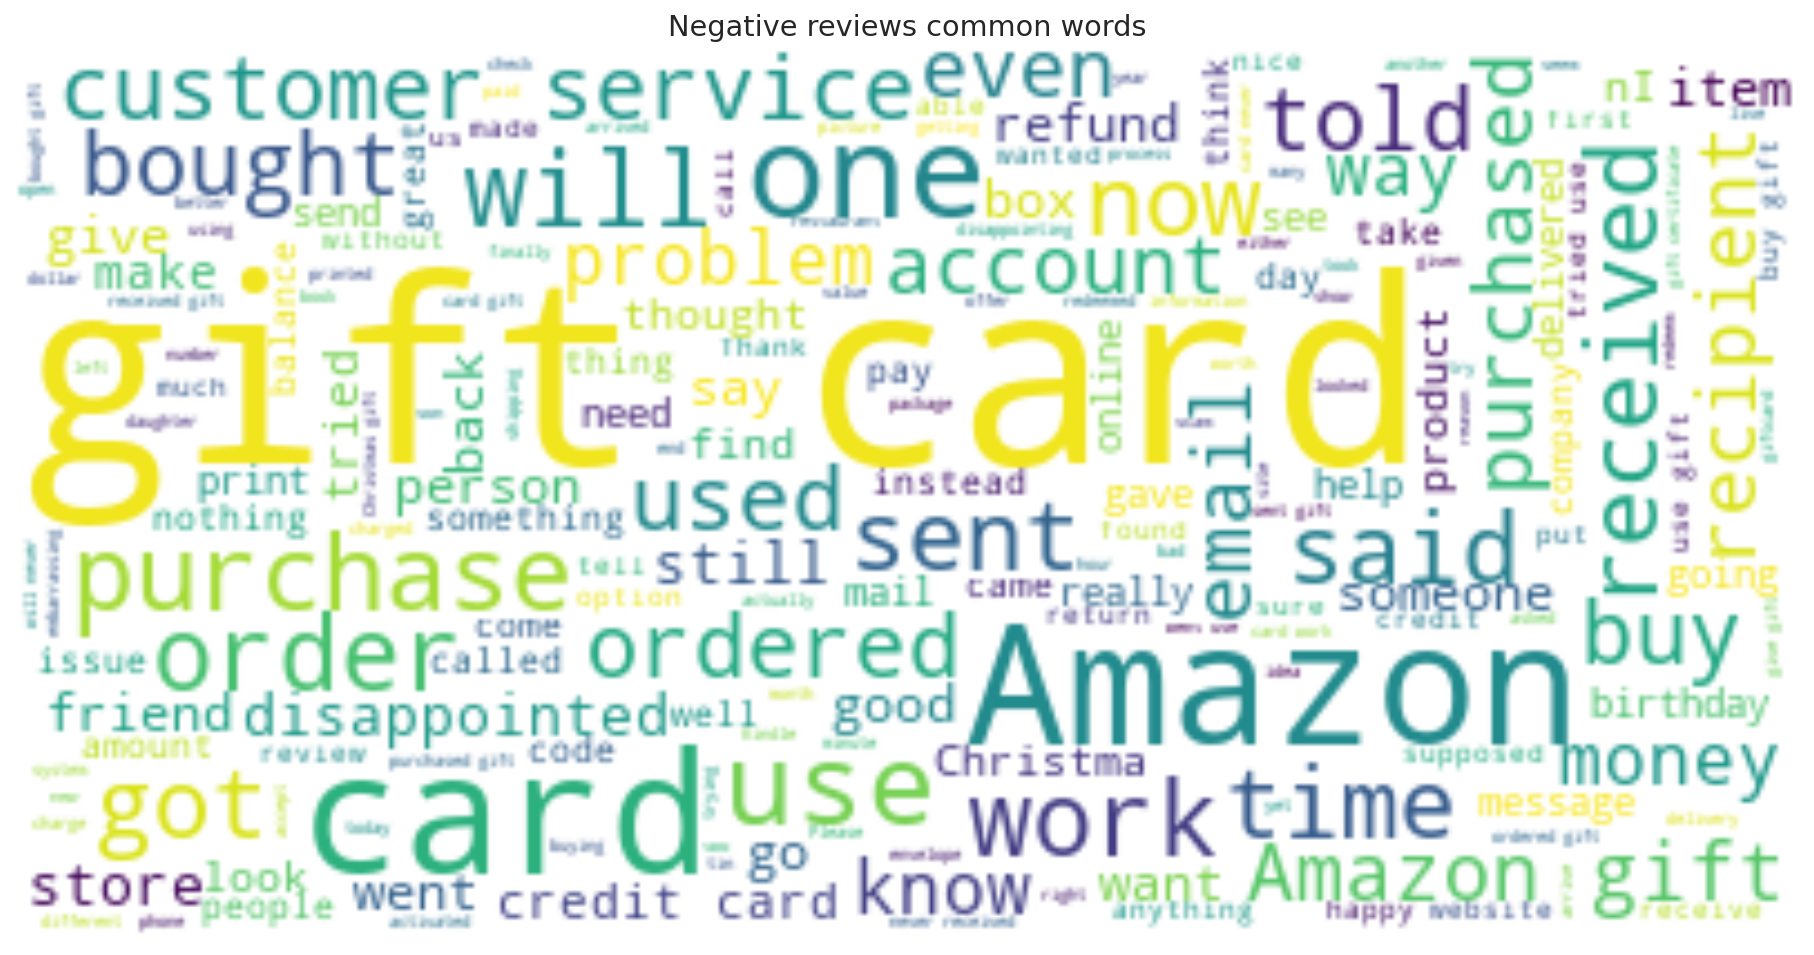

In [ ]:
show_word_cloud(negative_reviews_cloud, "Negative reviews common words")

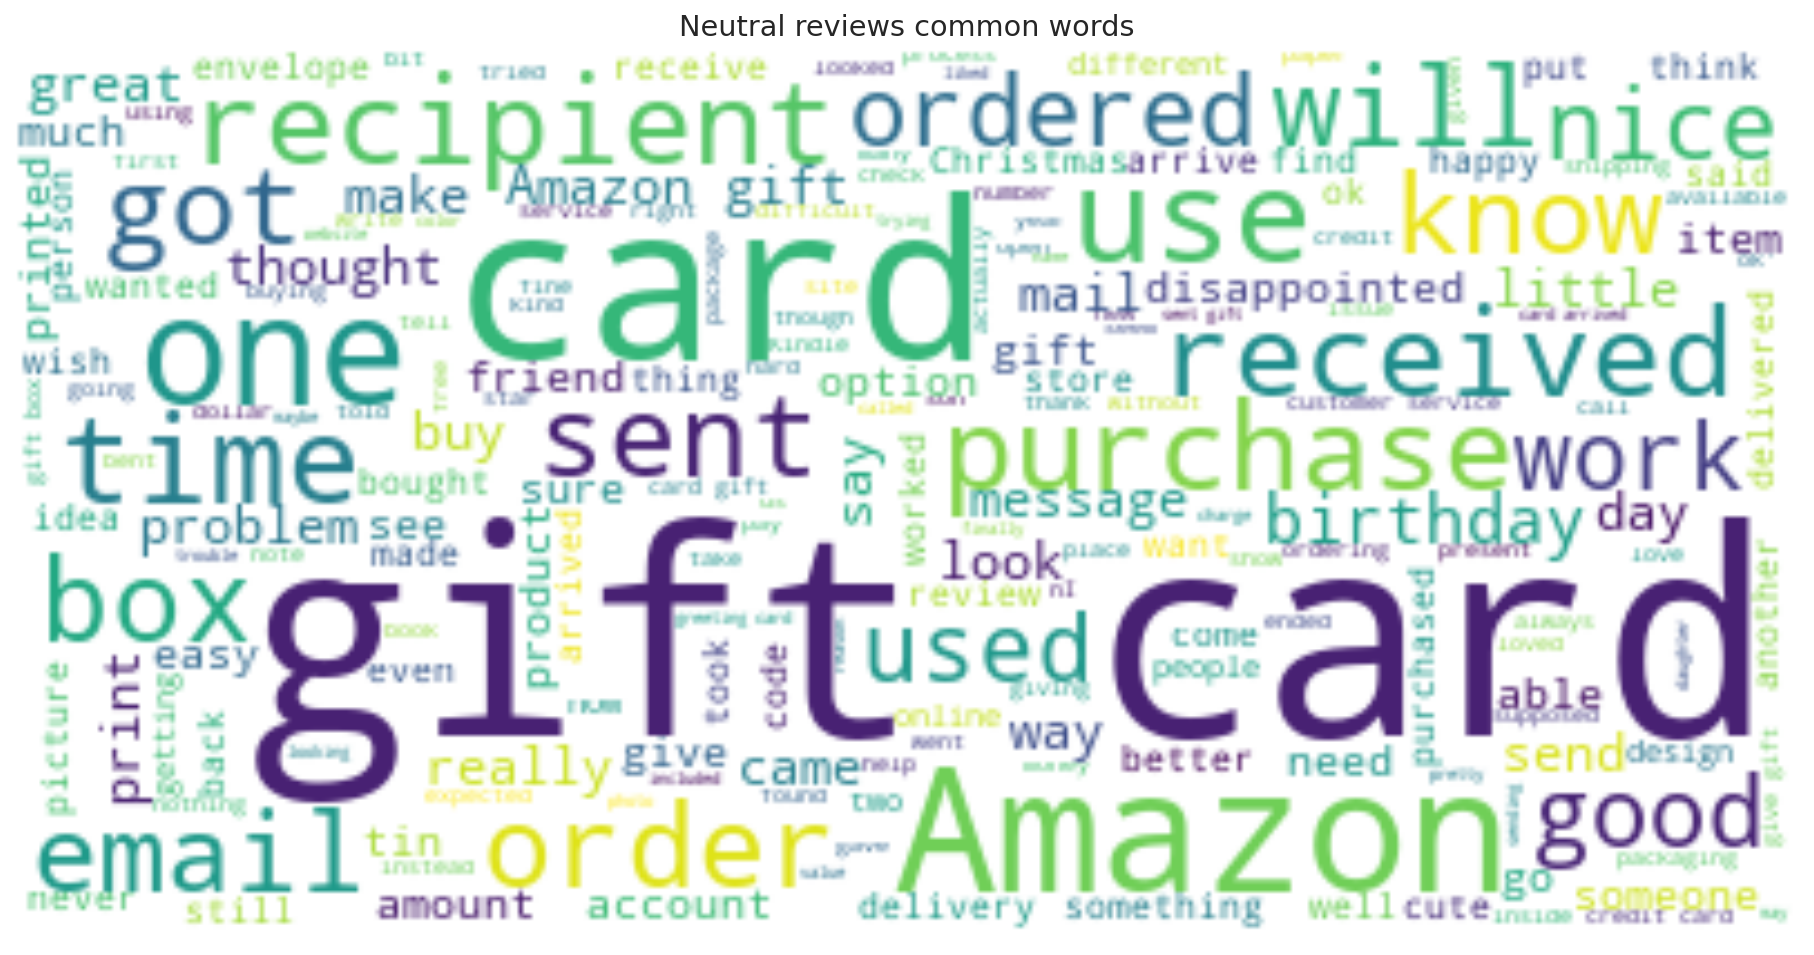

In [ ]:
show_word_cloud(neutral_reviews_cloud, "Neutral reviews common words")

Sampling a subset of positive reviews to eliminate skew in the Dataset

In [ ]:
positive_review_df = positive_reviews.sample(n=len(negative_reviews), random_state=RANDOM_SEED)
negative_review_df = negative_reviews
neutral_reviews_df = neutral_reviews

In [ ]:
review_df=pd.concat([positive_review_df,negative_review_df,neutral_reviews_df])

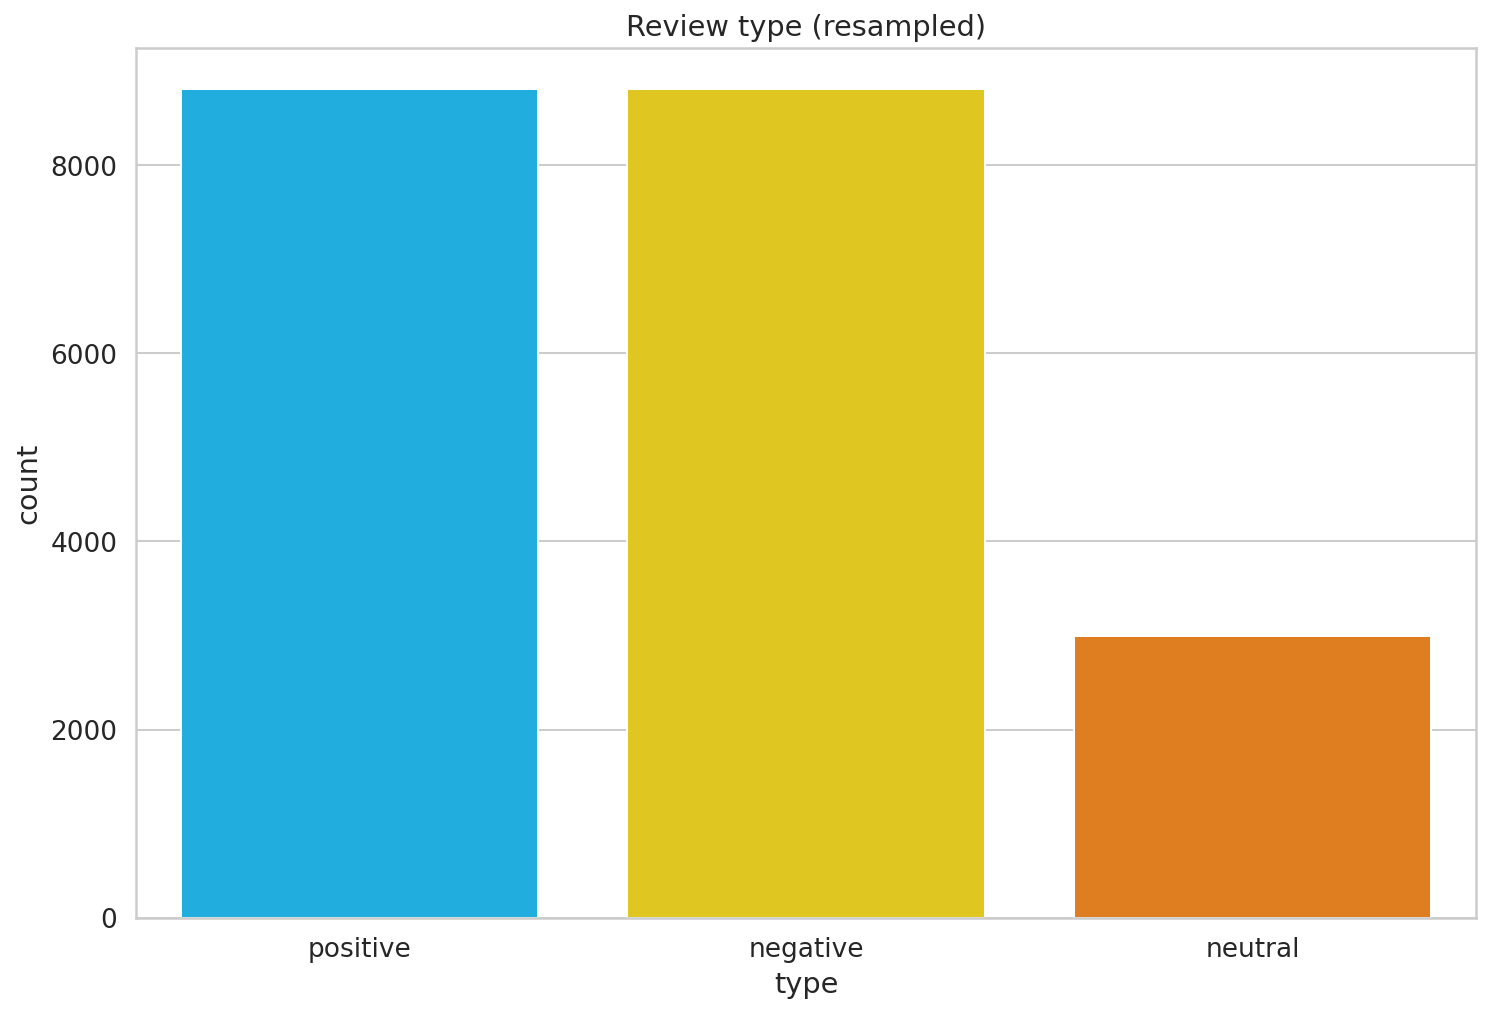

In [ ]:
sns.countplot(
  x='review_type',
  data=review_df,
  order=review_df.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type (resampled)");

In [ ]:
universal_sentence_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [ ]:
from sklearn.preprocessing import OneHotEncoder
type_one_hot = OneHotEncoder(sparse=False).fit_transform(
  review_df.review_type.to_numpy().reshape(-1, 1)
)

In [98]:
review_df.review_type

100007    positive
138887    positive
127080    positive
86649     positive
67896     positive
            ...   
147081     neutral
147088     neutral
147133     neutral
147138     neutral
147176     neutral
Name: review_type, Length: 20612, dtype: object

In [ ]:
from sklearn.model_selection import  train_test_split
train_reviews, test_reviews, y_train, y_test = train_test_split(review_df.reviewText,type_one_hot, test_size=.1, random_state=RANDOM_SEED)

In [ ]:
train_reviews.shape

(18550,)

In [ ]:
test_reviews.shape

(2062,)

Embedding review sentences using Universal Sentence Encoder

In [ ]:
X_train = []
for r in tqdm(train_reviews):
  emb = universal_sentence_encoder(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)
X_train = np.array(X_train)

In [ ]:
X_test = []
for r in tqdm(test_reviews):
  emb = universal_sentence_encoder(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)

In [117]:
X_train.shape[1]

512

Fully Connected Layers with Dropout

In [89]:
model = keras.Sequential()
model.add(
  keras.layers.Dense(
    units=256,
    input_shape=(X_train.shape[1], ),
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)

model.add(
  keras.layers.Dense(
    units=128,
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)

model.add(keras.layers.Dense(3, activation='softmax'))
model.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

In [90]:
history = model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
1044/1044 [==============================] - 3s 3ms/step - loss: 0.5737 - accuracy: 0.7863 - val_loss: 0.5016 - val_accuracy: 0.8043
Epoch 2/10
1044/1044 [==============================] - 3s 2ms/step - loss: 0.5102 - accuracy: 0.8110 - val_loss: 0.4886 - val_accuracy: 0.8167
Epoch 3/10
1044/1044 [==============================] - 3s 2ms/step - loss: 0.4876 - accuracy: 0.8174 - val_loss: 0.4917 - val_accuracy: 0.8092
Epoch 4/10
1044/1044 [==============================] - 3s 3ms/step - loss: 0.4754 - accuracy: 0.8255 - val_loss: 0.4773 - val_accuracy: 0.8135
Epoch 5/10
1044/1044 [==============================] - 3s 3ms/step - loss: 0.4557 - accuracy: 0.8299 - val_loss: 0.4782 - val_accuracy: 0.8189
Epoch 6/10
1044/1044 [==============================] - 3s 2ms/step - loss: 0.4396 - accuracy: 0.8359 - val_loss: 0.4847 - val_accuracy: 0.8151
Epoch 7/10
1044/1044 [==============================] - 3s 3ms/step - loss: 0.4224 - accuracy: 0.8412 - val_loss: 0.4870 - val_accuracy:

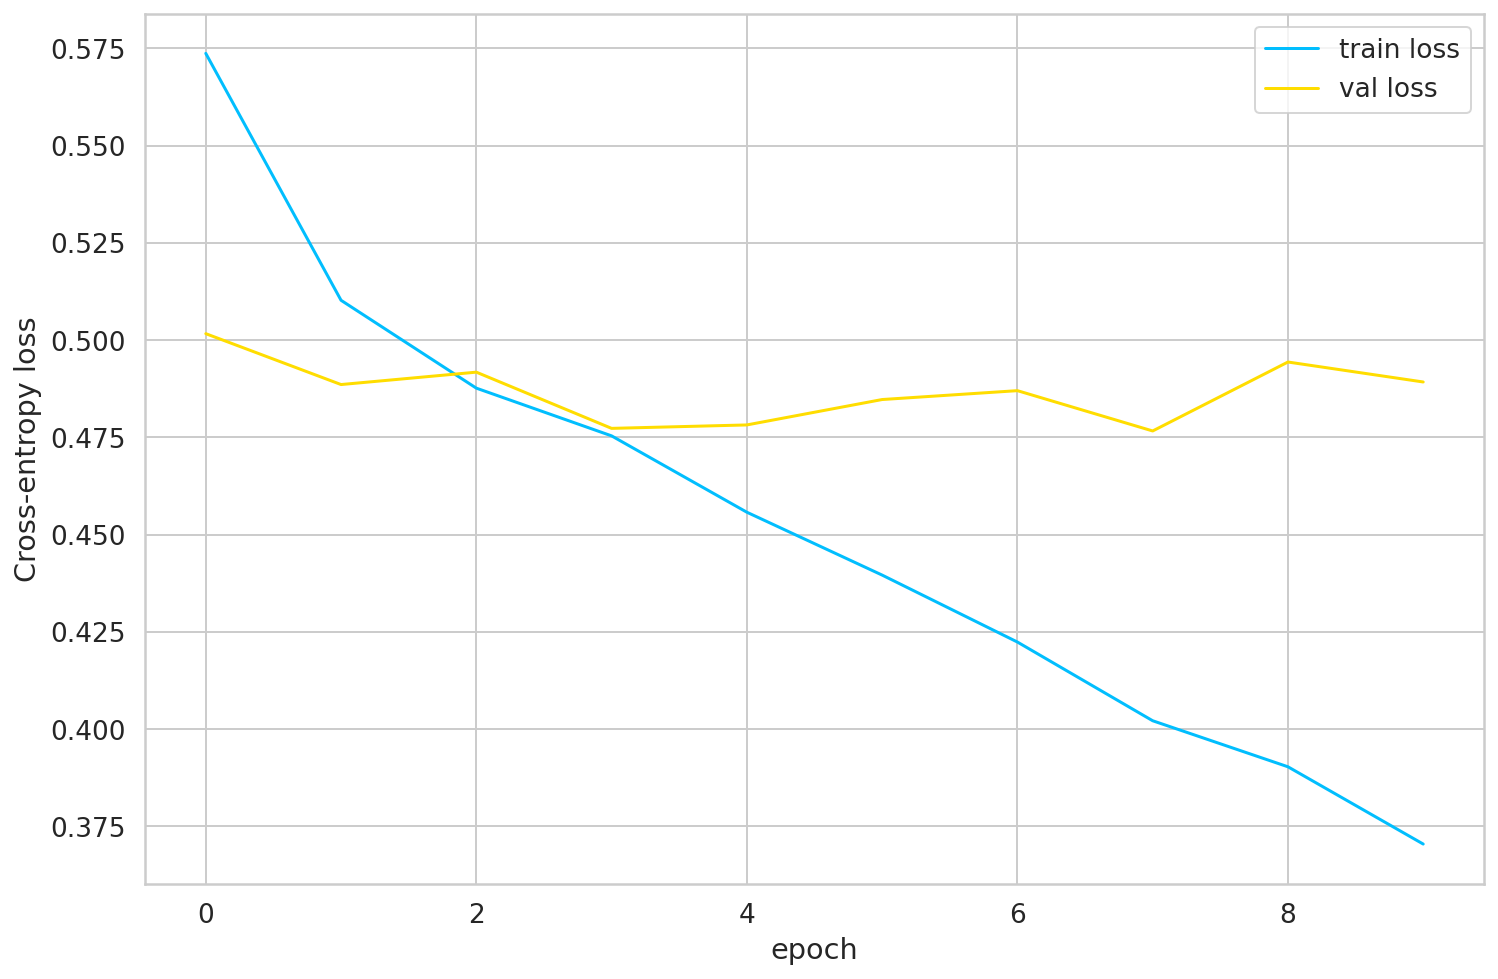

In [91]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();



*   Model overfits after 3 epochs



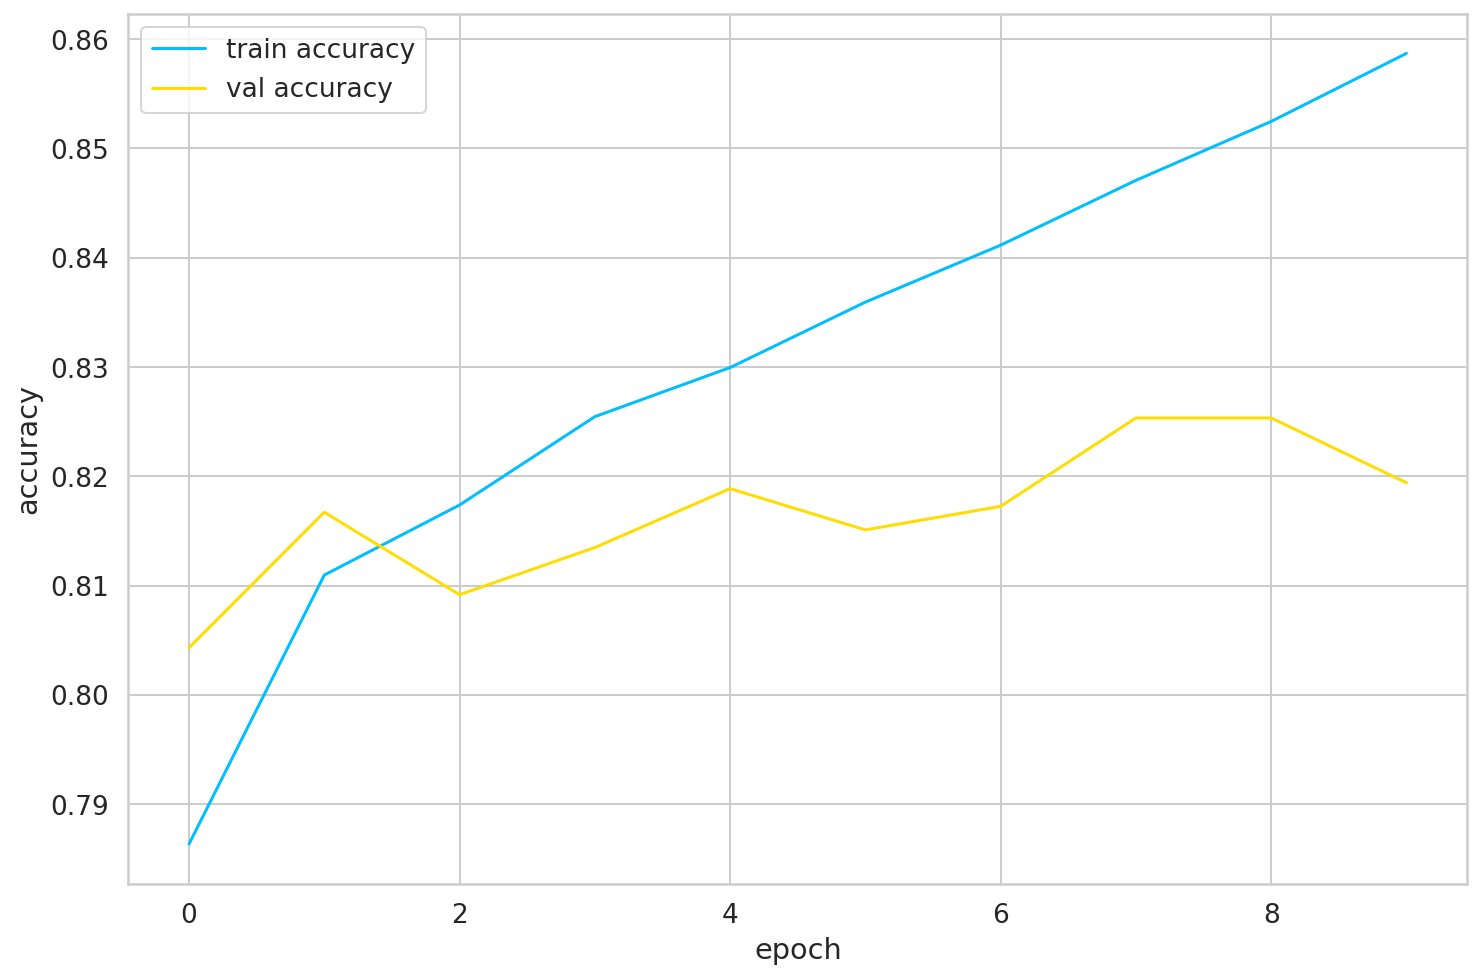

In [92]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [116]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:",loss)
print("Test Accuracy:",accuracy)

65/65 [==============================] - 0s 2ms/step - loss: 0.5198 - accuracy: 0.8065
Test Loss: 0.5198363065719604
Test Accuracy: 0.8064985275268555


Classification Metric

In [124]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_class=np.argmax(y_pred, axis=1)
y_true_class=np.argmax(y_test, axis=1)
print(classification_report(y_true_class, y_pred_class))

33/33 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       902
           1       0.45      0.20      0.28       301
           2       0.84      0.94      0.89       859

    accuracy                           0.81      2062
   macro avg       0.71      0.67      0.67      2062
weighted avg       0.78      0.81      0.78      2062



Testing Random Reviews

In [104]:
def get_review_prediction(X):
  y_pred=model.predict(X)
  if np.argmax(y_pred) == 2:
    return "Positive"
  elif np.argmax(y_pred)==1:
    return "Neutral"
  else:
    return "Negative"

In [115]:
index_num=252
print(test_reviews.iloc[index_num])
print(y_test[index_num])
print(get_review_prediction(X_test[index_num:index_num+1]))

received well in time for a Christmas gift.
[0. 0. 1.]
Positive
